## Code setup
### Import necessary packages and OOM modules

In [1]:
from matplotlib.collections import LineCollection
from matplotlib import pyplot as plt
from matplotlib import cm, colors
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

np.set_printoptions(linewidth=300, suppress=True)
pd.options.mode.chained_assignment = None  # default='warn'

from src.experiments.util_experiments import *
from src.oom import DiscreteValuedOOM, ContinuousValuedOOM
from src.oom.util.few_step_prediction import quantify_distribution

### Plotting functions for PCA decomposition and membership functions

In [18]:
def plot_pca_results(x_pca, y_pca, fig, ax, title, scale='auto'):
    ax.set_title(title)
    points = np.array([x_pca, y_pca]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis = 1)
    cols = np.linspace(0, 1, len(x_pca))

    cmap = sns.color_palette("flare", as_cmap=True)
    lc = LineCollection(segments, cmap = cmap, alpha = 0.5)
    lc.set_array(cols)
    lc.set_linewidth(0.15)
    line = ax.add_collection(lc)

    if scale == 'auto':
        ax.autoscale()
    else:
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
    
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
    fig.colorbar(line, ax = ax)

def make_plot(oom, gen, fig, ax, title):
    pvecs = np.vstack([pvec for pvec in gen.p_vec_list if not np.any(np.isnan(pvec))])
    
    pvs_embeds_pca = PCA(n_components = 2).fit_transform(pvecs)
    
    x_pca = pvs_embeds_pca[:,0]
    y_pca = pvs_embeds_pca[:,1]
    
    plot_pca_results(x_pca, y_pca, fig, ax, title, scale=0)

def plot_mfs(cvoom, fig, ax, title, xlim = (-5, 5)):
    xlimi, xlims = xlim
    ax.set_title(title)
    ax.set_xlim([xlimi, xlims])
    
    x = np.linspace(xlimi, xlims, (xlims - xlimi) * 1000)
    for obs, mf in zip(cvoom.observables, cvoom.membership_fns):
        ax.plot(x, mf.pdf(x), label=obs.uid)
    ax.legend()

    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

## Determining good HMM sources

The code runs through ```MAX_SEEDS``` seeds and attempts to simultaneously:
- minimize the spectral gap of the HMM transition matrix (lower -> likely more complex process);
- maximize the geometric mean of variances across the first two principal axes PC1 and PC2 for a 10_000-step generation;

This yields the "ideal" seed for the discrete HMM source for the chosen alphabet size ```n``` at dimension ```d``` and with sparsity ```1-density```.

The following step is choosing a seed for membership function generation to maximize the same task. Since the spectral gap of the continuous HMM is the same as for the discrete one ($\tau_\Sigma = \tau_I$), this amounts to maximizing the geometric mean by itself across ```MAX_SEEDS``` possible runs.

In [3]:
n = 3
d = 10
density = 0.2
MAX_SEEDS = 200

#### Optimizing for the discrete-valued (symbolic) source

In [2]:
def optimize_discrete(n: int, d: int, density: float, max_seeds: int) -> pd.Series:
    # Define results dictionary
    metrics_dv = {
        "spectral_gap": [],
        "geo_mean_var": [],
        "perc0fs_at_7": []
    }

    # Iterate through first max_seeds seeds
    description = f"Discrete-Valued Source Optimization ({n=} {d=} {density=})"
    for DVSEED in tqdm(range(max_seeds), desc = description):
        # Create source OOM as an HMM with the given paramters for this seed
        oom_disc = make_source(dimension = d, alphabet_size = n, density = density, seed = DVSEED)

        quant7 = quantify_distribution(steps=7, state=oom_disc.start_state, operators=oom_disc.operators, lin_func=oom_disc.lin_func)
        perc0fs_at_7 = np.average(quant7 == 0)
        # print(perc0fs_at_7)
        if perc0fs_at_7 > n**(-2):
            continue
        
        # Compute spectral gap
        transition_matrix = np.sum(oom_disc.operators, axis = 0)
        eigenvalues, _ = np.linalg.eig(transition_matrix)
        eigenvalues = np.sort(np.abs(eigenvalues))[::-1]  # Sort eigenvalues
        spectral_gap = eigenvalues[0] - eigenvalues[1]    # Spectral gap
    
        # Compute geometric mean of variances on PC1, PC2 axes
        gen = oom_disc.generate(10000, reduced = False)
        pvecs = np.vstack([pvec for pvec in gen.p_vec_list if not np.any(np.isnan(pvec))])
        pvs_embeds_pca = PCA(n_components = 2).fit_transform(pvecs)
        x_pca = pvs_embeds_pca[:,0]
        y_pca = pvs_embeds_pca[:,1]
        var_pc1 = np.var(x_pca)
        var_pc2 = np.var(y_pca)
        geometric_mean = np.sqrt(var_pc1 * var_pc2)
    
        # Save results
        metrics_dv["spectral_gap"].append(spectral_gap)
        metrics_dv["geo_mean_var"].append(geometric_mean)
        metrics_dv["perc0fs_at_7"].append(perc0fs_at_7)

    # Convert to pandas
    metrics_dv_df = pd.DataFrame(metrics_dv)

    # print(metrics_dv)

    # Process and reorder columns
    metrics_dv_df = metrics_dv_df.reset_index().rename({"index": "DVSEED"}, axis = 1)
    metrics_dv_df["norm_spectral_gap"] = 1 - (metrics_dv_df["spectral_gap"] - metrics_dv_df["spectral_gap"].min()) / (metrics_dv_df["spectral_gap"].max() - metrics_dv_df["spectral_gap"].min())
    metrics_dv_df["norm_geo_mean_var"] = (metrics_dv_df["geo_mean_var"] - metrics_dv_df["geo_mean_var"].min()) / (metrics_dv_df["geo_mean_var"].max() - metrics_dv_df["geo_mean_var"].min())
    metrics_dv_df["norm_weighted_sum"] = 0.5 * (metrics_dv_df["norm_spectral_gap"] + metrics_dv_df["norm_geo_mean_var"])
    metrics_dv_df = metrics_dv_df.sort_values(by = "norm_weighted_sum", ascending = False)
    metrics_dv_df = metrics_dv_df.reset_index(drop = True)

    dv_seed_best = metrics_dv_df["DVSEED"].iloc[0]
    oom_disc_stats = metrics_dv_df.iloc[0]
    
    return dv_seed_best, oom_disc_stats, metrics_dv_df

##### Other

In [3]:
dv_seed_best, best_dv_stats, all_metrics = optimize_discrete(n, d, density, MAX_SEEDS)
all_metrics

NameError: name 'n' is not defined

In [30]:
print(f"Best seed: {dv_seed_best}\n\nMetrics for best seed:\n{best_dv_stats}")

Best seed: 63

Metrics for best seed:
DVSEED              63.00000
spectral_gap         0.05357
geo_mean_var         0.21171
norm_spectral_gap    0.85483
norm_geo_mean_var    0.97212
norm_weighted_sum    0.91347
Name: 0, dtype: float64


In [32]:
oom_disc = make_source(dimension = d, alphabet_size = n, density = density, seed = dv_seed_best)

#### Optimizing for the continuous (blended) source's membership functions

In [8]:
def optimize_continuous(dvoom: DiscreteValuedOOM, max_seeds: int):
    # Define results dictionary
    metrics_cv = {
        "geo_mean_var": []
    }

    d = dvoom.dim
    n = len(dvoom.observables)
    
    # Iterate through first max_seeds seeds
    description = f"Blended Source Optimization ({n=} {d=})"
    for MFSEED in tqdm(range(max_seeds), desc = description):
        # Create source blended OOM with random Gaussians for this seed
        mfs = get_gaussian(seed = MFSEED)(n)
        oom_cont = ContinuousValuedOOM.from_discrete_valued_oom(dvoom, mfs)
        
        # Compute geometric mean of variances on PC1, PC2 axes
        gen = oom_cont.generate(10000, reduced = False)
        pvecs = np.vstack([pvec for pvec in gen.p_vec_list if not np.any(np.isnan(pvec))])
        pvs_embeds_pca = PCA(n_components = 2).fit_transform(pvecs)
        x_pca = pvs_embeds_pca[:,0]
        y_pca = pvs_embeds_pca[:,1]
        var_pc1 = np.var(x_pca)
        var_pc2 = np.var(y_pca)
        geometric_mean = np.sqrt(var_pc1 * var_pc2)
    
        # Save results
        metrics_cv["geo_mean_var"].append(geometric_mean)

    # Convert to pandas
    metrics_cv_df = pd.DataFrame(metrics_cv)

    # Process and reorder columns
    metrics_cv_df = metrics_cv_df.reset_index().rename({"index": "MFSEED"}, axis = 1)
    metrics_cv_df["norm_geo_mean_var"] = (metrics_cv_df["geo_mean_var"] - metrics_cv_df["geo_mean_var"].min()) / (metrics_cv_df["geo_mean_var"].max() - metrics_cv_df["geo_mean_var"].min())
    metrics_cv_df = metrics_cv_df.sort_values(by = "norm_geo_mean_var", ascending = False)
    metrics_cv_df = metrics_cv_df.reset_index(drop = True)

    mf_seed_best = metrics_cv_df["MFSEED"].iloc[0]
    oom_cont_stats = metrics_cv_df.iloc[0]

    return mf_seed_best, oom_cont_stats, metrics_cv_df

##### Other

In [36]:
mf_seed_best, best_mf_stats, all_metrics_mf = optimize_continuous(oom_disc, MAX_SEEDS)
all_metrics_mf

Blended Source Optimization: 100%|███████████████████████████████████████████████████| 200/200 [04:17<00:00,  1.29s/it]


,MFSEED,geo_mean_var,norm_geo_mean_var
0,6,0.22332,1.00000
1,181,0.22228,0.99496
2,26,0.22203,0.99375
3,136,0.22195,0.99337
4,192,0.21999,0.98394
...,...,...,...
195,156,0.06062,0.21635
196,12,0.06028,0.21468
197,119,0.04934,0.16199
198,157,0.02993,0.06854


In [37]:
print(f"Best seed: {mf_seed_best}\n\nMetrics for best seed:\n{best_mf_stats}")

Best seed: 6

Metrics for best seed:
MFSEED              6.00000
geo_mean_var        0.22332
norm_geo_mean_var   1.00000
Name: 0, dtype: float64


In [38]:
mfs = get_gaussian(seed = mf_seed_best)(n)
oom_cont = ContinuousValuedOOM.from_discrete_valued_oom(oom_disc, mfs)

### Visualizing best results

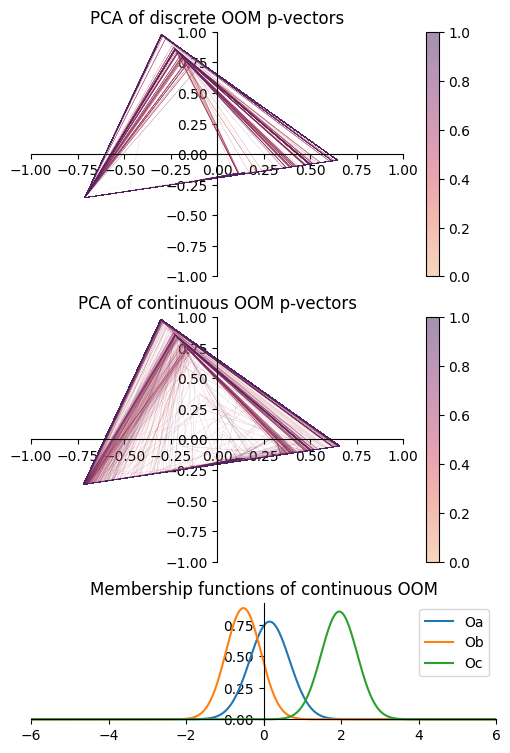

In [39]:
fig, axs = plt.subplots(3, 1, figsize=(6, 9), height_ratios=[1, 1, 0.5])
axs = axs.flatten()

# oom_disc = make_source(dimension = d, alphabet_size = n, density = density, seed = 10)
# mfs = get_gaussian(seed = 10)(n)
# oom_cont = ContinuousValuedOOM.from_discrete_valued_oom(oom_disc, mfs)

gen_disc = oom_disc.generate(10000, reduced = False)
gen_cont = oom_cont.generate(10000, reduced = False)

make_plot(oom_disc, gen_disc, fig, axs[0], "PCA of discrete OOM p-vectors")
make_plot(oom_cont, gen_cont, fig, axs[1], "PCA of continuous OOM p-vectors")
plot_mfs(oom_cont, fig, axs[2], "Membership functions of continuous OOM", xlim=(-6, 6))

### Assessing the membership function parameters (Gaussians)

In [40]:
mfs_props = []
for mf in oom_cont.membership_fns:
    mfs_props.append(mf.__dict__['kwds'])
mfs_props_df = pd.DataFrame.from_records(mfs_props)
mfs_props_df = mfs_props_df.rename({'loc': 'mean', 'scale': 'var'}, axis = 1).sort_values(by = 'mean')
mfs_props_df

,mean,var
1,-0.52373,0.45101
0,0.15266,0.51346
2,1.94978,0.46551


## Repeating the process for different source parameters

In [4]:
MAX_SEEDS = 200

best_stats = []

for (n, d, density) in [(3, 10, 0.3), (3, 10, 0.4), (5, 10, 0.3), (5, 10, 0.4)]:
    # Optimize discrete-valued OOM seed
    _dv_seed_best, _best_dv_stats, _all_metrics = optimize_discrete(n, d, density, MAX_SEEDS)
    print(f"{len(_all_metrics.index)} non-degenerate cases with best:\n", _best_dv_stats, sep='', end='\n\n')
    
    # For best discrete-valued OOM seed, optimize membership function seed
    _oom_disc = make_source(dimension = d, alphabet_size = n, density = density, seed = _dv_seed_best)
    _mf_seed_best, _best_mf_stats, _all_metrics_mf = optimize_continuous(_oom_disc, MAX_SEEDS)

    # Combine results and save
    source_params = pd.Series([n, d, density], index = ["alphabet_size", "dimension", "density"])
    all_src = pd.concat([source_params, _best_dv_stats, _best_mf_stats])
    best_stats.append(all_src)

Discrete-Valued Source Optimization (n=3 d=10 density=0.3): 100%|████████████████████| 200/200 [01:21<00:00,  2.45it/s]


75 non-degenerate cases with best:
DVSEED               21.000000
spectral_gap          0.181829
geo_mean_var          0.099866
perc0fs_at_7          0.000000
norm_spectral_gap     0.685767
norm_geo_mean_var     1.000000
norm_weighted_sum     0.842883
Name: 0, dtype: float64



Blended Source Optimization (n=3 d=10 density=0.3): 100%|████████████████████████████| 200/200 [04:33<00:00,  1.37s/it]
Discrete-Valued Source Optimization (n=3 d=10 density=0.4): 100%|████████████████████| 200/200 [02:41<00:00,  1.24it/s]


164 non-degenerate cases with best:
DVSEED               81.000000
spectral_gap          0.209541
geo_mean_var          0.045881
perc0fs_at_7          0.000000
norm_spectral_gap     0.762783
norm_geo_mean_var     1.000000
norm_weighted_sum     0.881392
Name: 0, dtype: float64



Blended Source Optimization (n=3 d=10 density=0.4): 100%|████████████████████████████| 200/200 [04:25<00:00,  1.33s/it]
Discrete-Valued Source Optimization (n=5 d=10 density=0.3): 100%|████████████████████| 200/200 [07:11<00:00,  2.16s/it]


8 non-degenerate cases with best:
DVSEED               3.000000
spectral_gap         0.322617
geo_mean_var         0.039856
perc0fs_at_7         0.023488
norm_spectral_gap    0.561849
norm_geo_mean_var    0.946682
norm_weighted_sum    0.754265
Name: 0, dtype: float64



Blended Source Optimization (n=5 d=10 density=0.3): 100%|████████████████████████████| 200/200 [04:34<00:00,  1.37s/it]
Discrete-Valued Source Optimization (n=5 d=10 density=0.4): 100%|████████████████████| 200/200 [08:39<00:00,  2.60s/it]


98 non-degenerate cases with best:
DVSEED               79.000000
spectral_gap          0.073037
geo_mean_var          0.026557
perc0fs_at_7          0.000038
norm_spectral_gap     1.000000
norm_geo_mean_var     0.614504
norm_weighted_sum     0.807252
Name: 0, dtype: float64



Blended Source Optimization (n=5 d=10 density=0.4): 100%|████████████████████████████| 200/200 [04:36<00:00,  1.38s/it]


In [5]:
# Save final outputs
tot_res = pd.concat(best_stats, axis = 1).transpose()
tot_res = tot_res.astype({'alphabet_size': 'int32', 'dimension': 'int32', 'DVSEED': 'int32', 'MFSEED': 'int32'})
tot_res

,alphabet_size,dimension,density,DVSEED,spectral_gap,geo_mean_var,perc0fs_at_7,norm_spectral_gap,norm_geo_mean_var,norm_weighted_sum,MFSEED,geo_mean_var,norm_geo_mean_var
0,3,10,0.3,21,0.181829,0.099866,0.000000,0.685767,1.000000,0.842883,174,0.007011,1.0
1,3,10,0.4,81,0.209541,0.045881,0.000000,0.762783,1.000000,0.881392,85,0.012094,1.0
2,5,10,0.3,3,0.322617,0.039856,0.023488,0.561849,0.946682,0.754265,194,0.020589,1.0
3,5,10,0.4,79,0.073037,0.026557,0.000038,1.000000,0.614504,0.807252,130,0.004702,1.0


In [12]:
_mf_seed_best, _best_mf_stats, _all_metrics_mf = optimize_continuous(make_source(name="S_3", case="discrete"), 200)

Blended Source Optimization (n=3 d=10): 100%|████████████████████████████████████████| 200/200 [04:23<00:00,  1.32s/it]


In [13]:
_best_mf_stats

MFSEED               3.000000
geo_mean_var         0.007035
norm_geo_mean_var    1.000000
Name: 0, dtype: float64

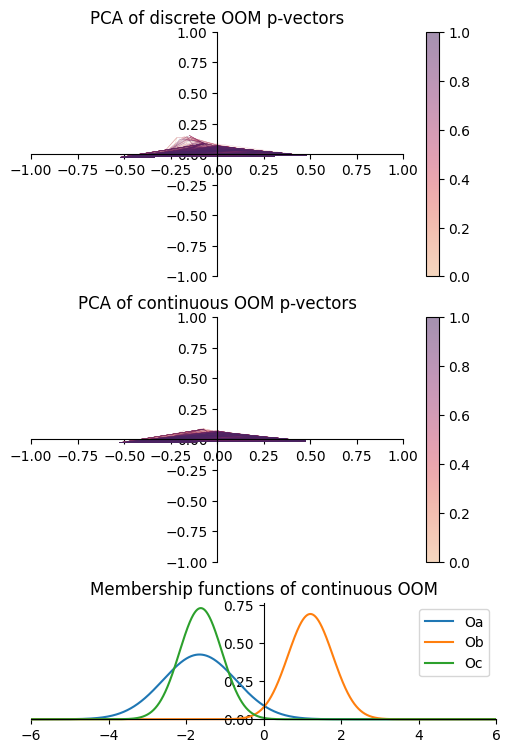

In [20]:
fig, axs = plt.subplots(3, 1, figsize=(6, 9), height_ratios=[1, 1, 0.5])
axs = axs.flatten()

# oom_disc = make_source(dimension = d, alphabet_size = n, density = density, seed = 10)
# mfs = get_gaussian(seed = 10)(n)
# oom_cont = ContinuousValuedOOM.from_discrete_valued_oom(oom_disc, mfs)
oom_disc = make_source(name="S_3", case="discrete")
oom_cont = ContinuousValuedOOM.from_discrete_valued_oom(
    oom_disc,
    membership_functions=get_gaussian(seed=int(_best_mf_stats['MFSEED']))(len(oom_disc.observables))
)

gen_disc = oom_disc.generate(10000, reduced = False)
gen_cont = oom_cont.generate(10000, reduced = False)

make_plot(oom_disc, gen_disc, fig, axs[0], "PCA of discrete OOM p-vectors")
make_plot(oom_cont, gen_cont, fig, axs[1], "PCA of continuous OOM p-vectors")
plot_mfs(oom_cont, fig, axs[2], "Membership functions of continuous OOM", xlim=(-6, 6))